🎬 Box Office Revenue Prediction: A Comprehensive Analysis

~by Roshan Prakash

Setup and Data Loading

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/roshanprakash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Creating log transformations for better visualization
train['log_budget'] = np.log1p(train['budget'])
train['log_revenue'] = np.log1p(train['revenue'])

Task 1: Exploratory Data Analysis

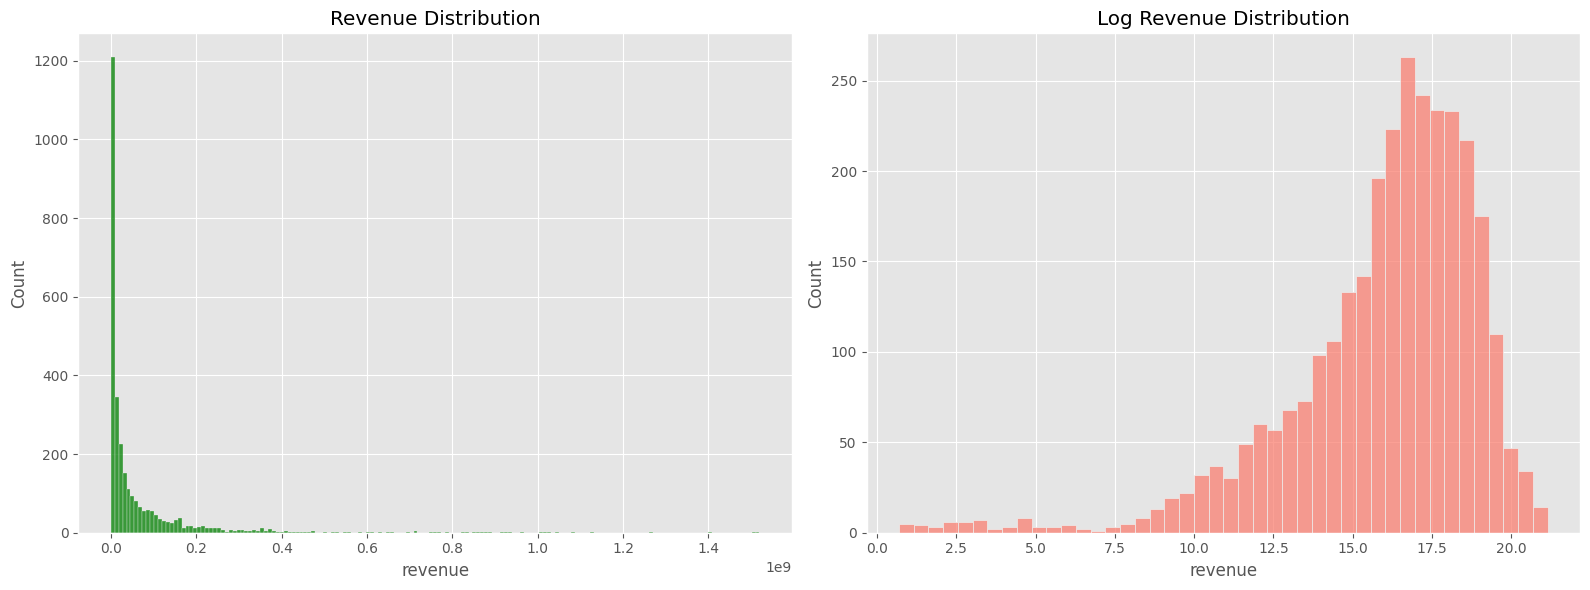

In [53]:
# 1.1Target Variable Distribution:
# Setting up the figure and axes for a side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the distribution of revenue
sns.histplot(train['revenue'], kde=False, ax=axes[0], color='green')
axes[0].set_title('Revenue Distribution')

# Plotting the distribution of log-transformed revenue
# Note: It's safer to use np.log1p for log transformation as it handles zero revenue cases gracefully
sns.histplot(np.log1p(train['revenue']), kde=False, ax=axes[1], color='salmon')
axes[1].set_title('Log Revenue Distribution')

plt.tight_layout()  # Adjusting subplots to fit into the figure area.
plt.show()

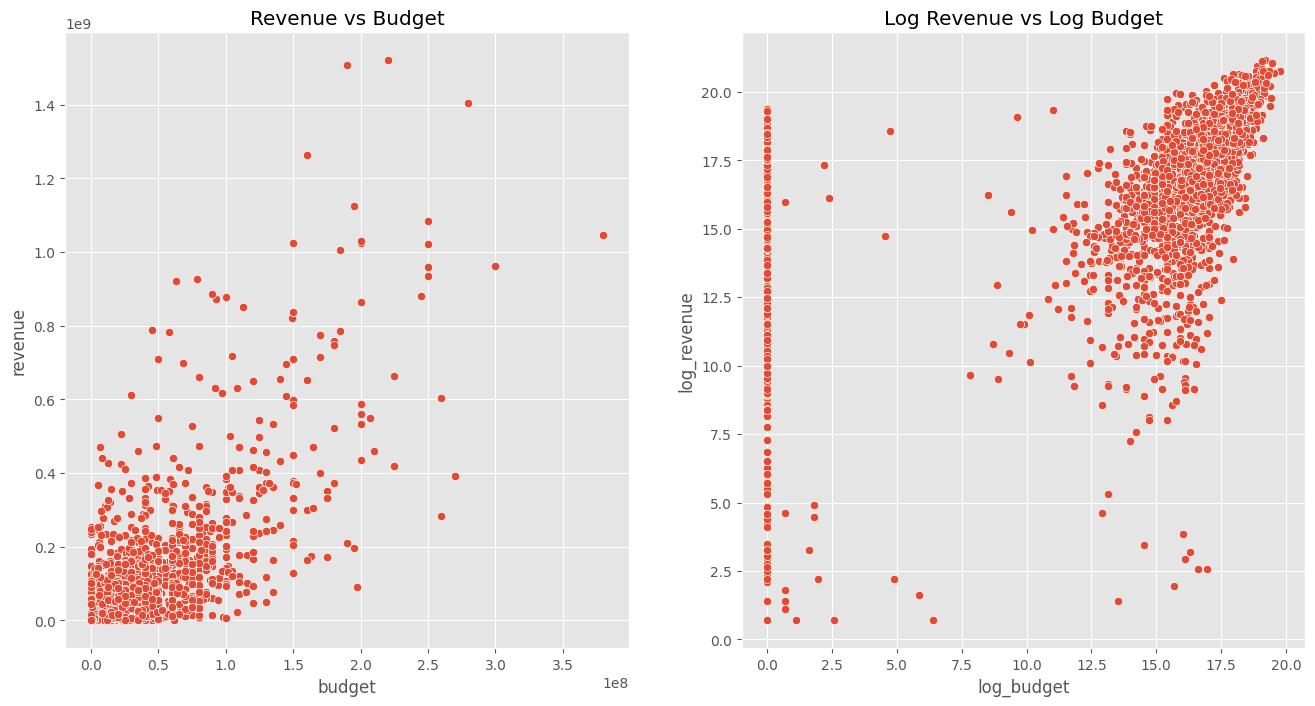

In [54]:
# 1.2 Revenue vs. Budget
plt.figure(figsize=(16, 8))

# Plotting Revenue vs Budget
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='revenue', data=train)
plt.title('Revenue vs Budget')

# Plotting Log Revenue vs Log Budget
plt.subplot(1, 2, 2)
sns.scatterplot(x='log_budget', y='log_revenue', data=train)
plt.title('Log Revenue vs Log Budget')

plt.show()

In [26]:
# Count the number of movies with top 10 most frequent homepages
train['homepage'].value_counts().head(10)

homepage
http://www.transformersmovie.com/                      4
http://www.thehobbit.com/                              2
http://www.lordoftherings.net/                         2
http://sonyclassics.com/whiplash/                      1
https://www.facebook.com/thefinesthoursmovie           1
http://sonyclassics.com/pariscanwait/                  1
http://www.maxpaynethemovie.com                        1
http://www.sonypictures.com/movies/afewgoodmen/        1
http://www.theasylum.cc/product.php?id=203             1
http://www.miramax.com/movie/the-cider-house-rules/    1
Name: count, dtype: int64

In [27]:
# 1.3 Impact of Homepage and Language
train['has_homepage'] = train['homepage'].notnull().astype(int)
test['has_homepage'] = test['homepage'].notnull().astype(int)

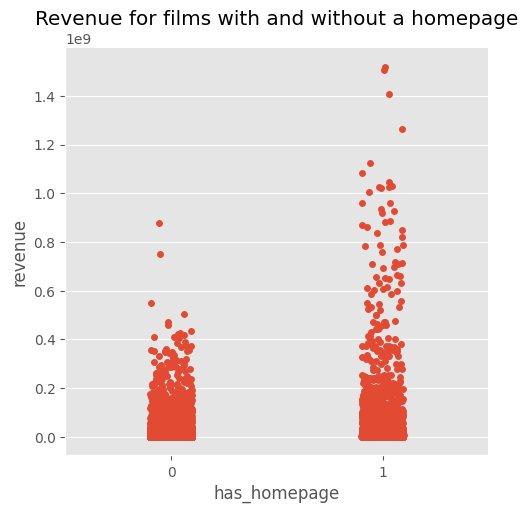

In [28]:
# Visualising the relationship
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for films with and without a homepage');

In [29]:
# Select top 10 most common languages
top_languages = train['original_language'].value_counts().head(10).index

# Filter data for only these top languages
language_data = train[train['original_language'].isin(top_languages)]


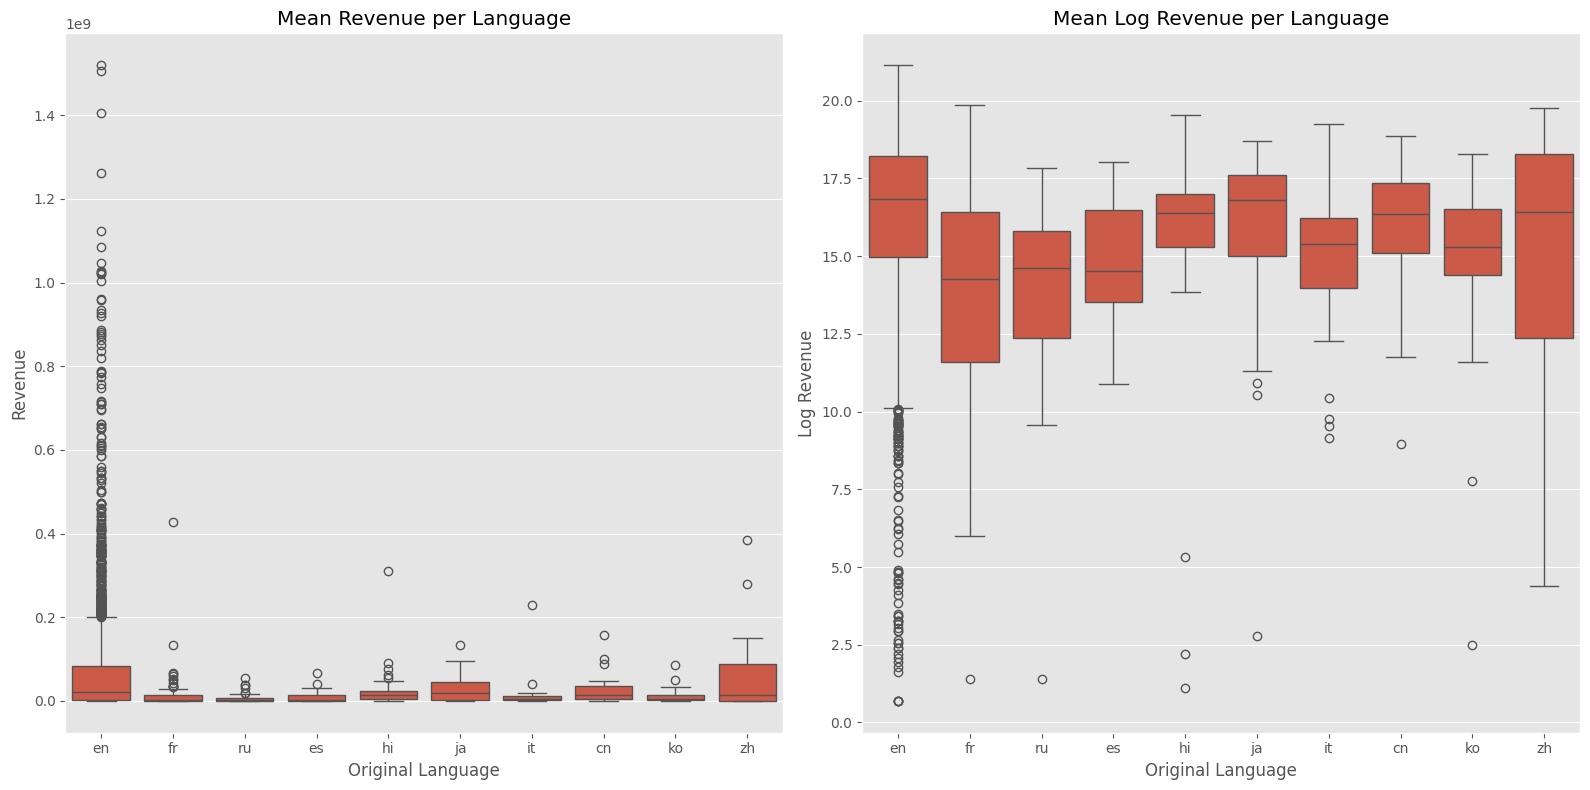

In [30]:
# Set up the plot
plt.figure(figsize=(16, 8))

# Plot mean revenue per language
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=language_data, order=top_languages)
plt.title('Mean Revenue per Language')
plt.xlabel('Original Language')
plt.ylabel('Revenue')

# Plot mean log revenue per language
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data, order=top_languages)
plt.title('Mean Log Revenue per Language')
plt.xlabel('Original Language')
plt.ylabel('Log Revenue')

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

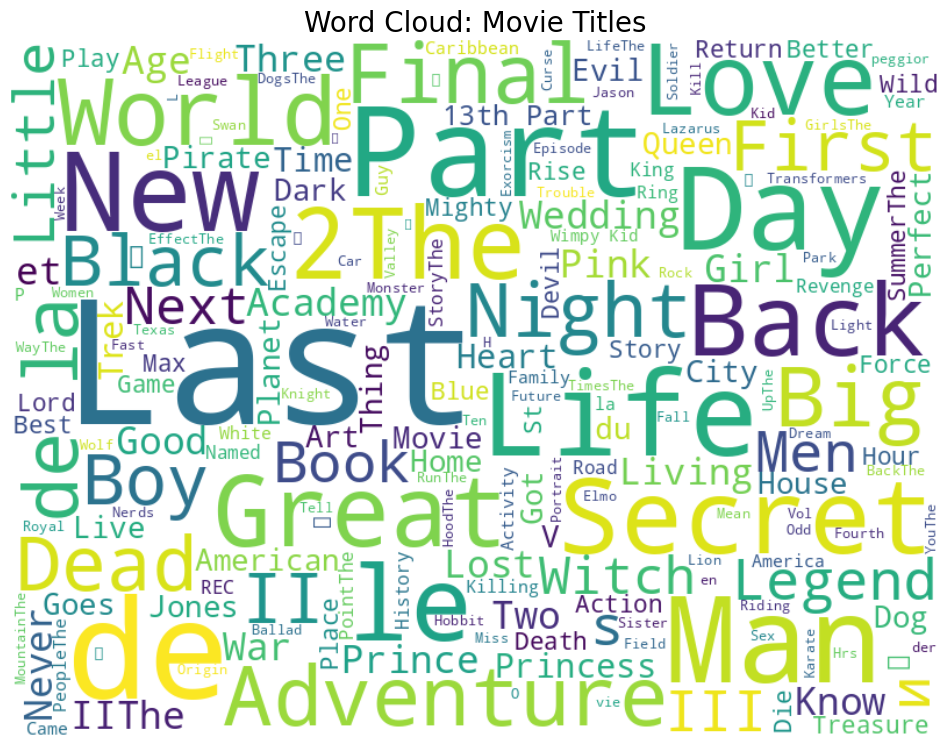

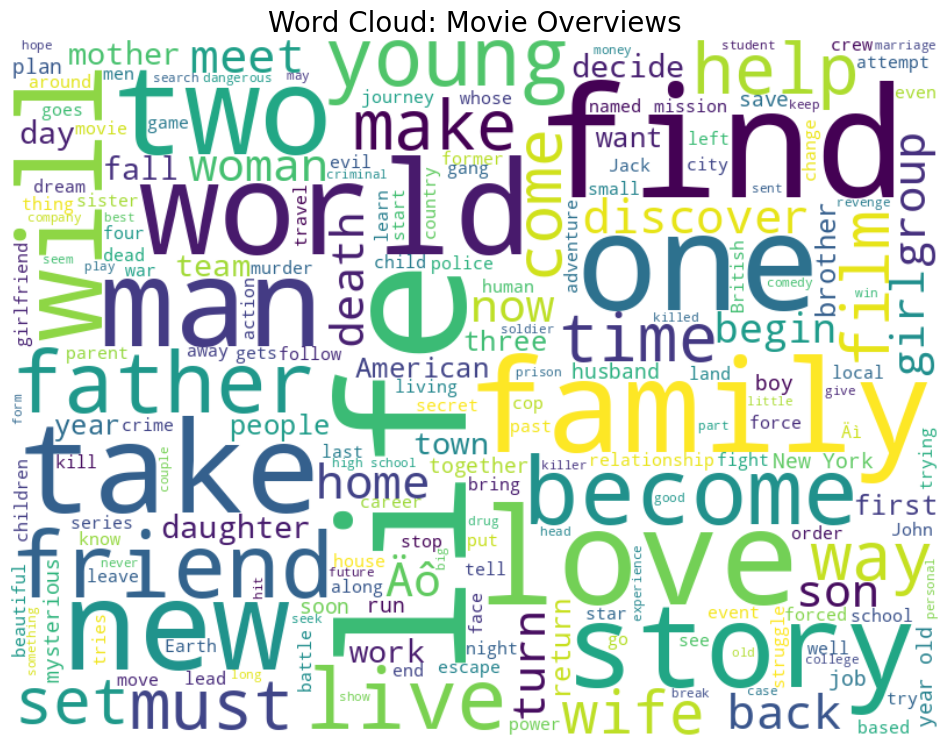

In [56]:
# 1.4 Word Clouds for Titles and Overviews

def plot_word_cloud(text, title):
    plt.figure(figsize=(12, 12))
    wordcloud = WordCloud(max_font_size=150, background_color='white', width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

plot_word_cloud(''.join(train['original_title'].values), 'Word Cloud: Movie Titles')
plot_word_cloud(''.join(train['overview'].fillna('').values), 'Word Cloud: Movie Overviews')

/var/folders/yw/4fw86bsd41j_mjrgzzbmnsmr0000gn/T/ipykernel_54290/934796363.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



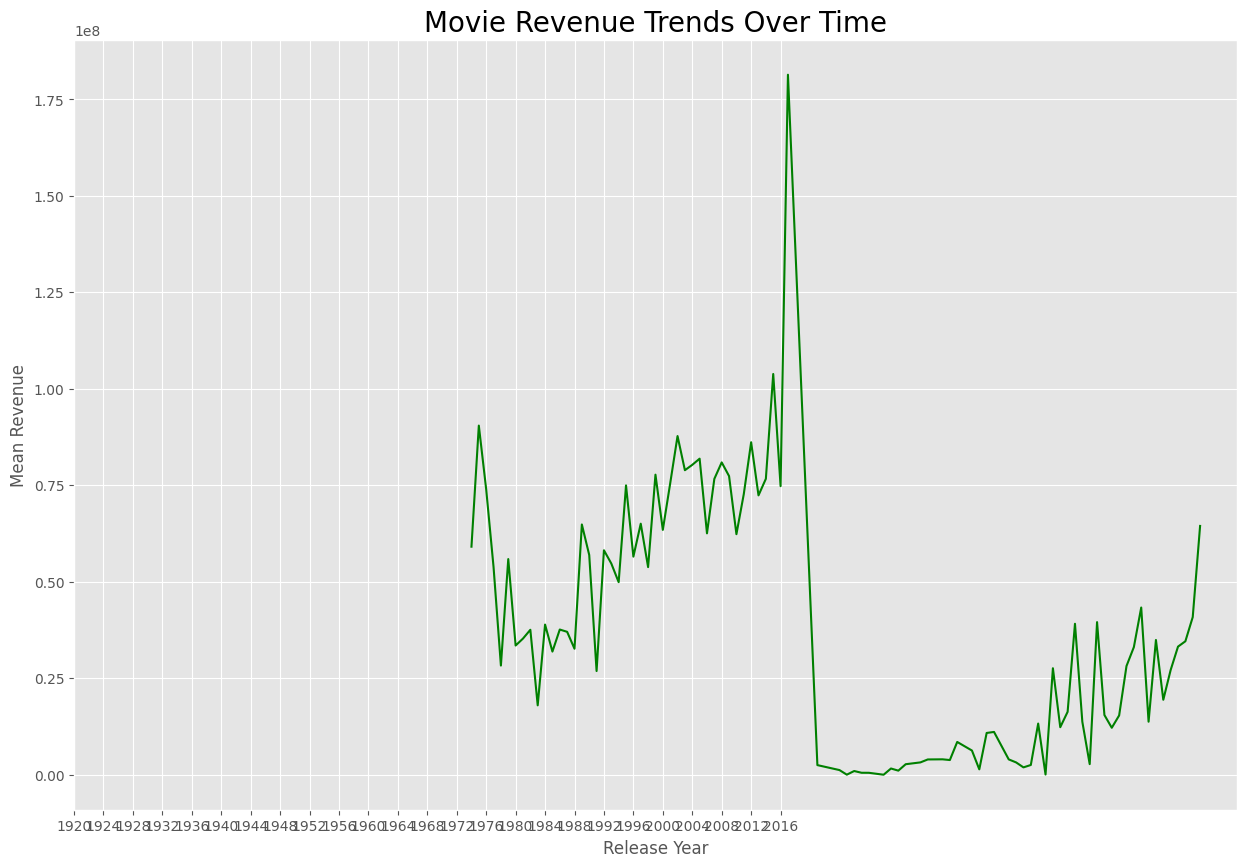

In [57]:
# Revenue Trends Over Time
train['release_year'] = pd.to_datetime(train['release_date'], errors='coerce').dt.year

plt.figure(figsize=(15, 10))
train.groupby('release_year')['revenue'].mean().plot(color='g')
plt.xticks(np.arange(1920, 2018, 4))
plt.xlabel("Release Year")
plt.ylabel("Mean Revenue")
plt.title("Movie Revenue Trends Over Time", fontsize=20)
plt.show()


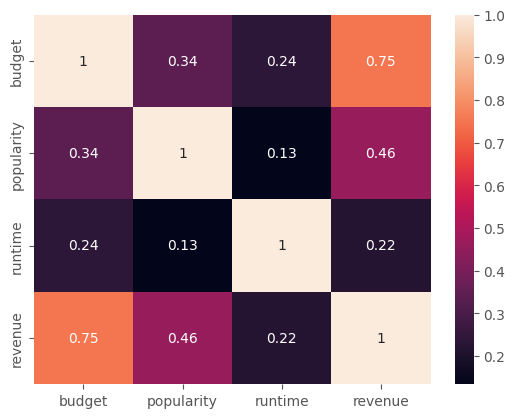

In [58]:
# Correlation heatmap for numerical columns
corr_matrix = train[['budget', 'popularity', 'runtime', 'revenue']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Feature Engineering and Modelling

In [45]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(overview_text, train['log_revenue'], test_size=0.2, random_state=42)

# Fit the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = linreg.predict(X_test)

# Define actual and predicted values for visualization
trace1 = go.Scatter(
    x=y_test.index,
    y=y_test.values,
    mode='markers',
    name='Actual'
)

trace2 = go.Scatter(
    x=y_test.index,
    y=y_pred,
    mode='lines',
    name='Predicted'
)

# Define layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Log Revenue',
    xaxis=dict(title='Sample Index'),
    yaxis=dict(title='Log Revenue')
)

# Combine traces and layout to create the plot
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)

# Save the plot as an HTML file
from plotly.offline import plot
plot(fig, filename='actual_vs_predicted_log_revenue.html')

# Or display the plot directly in the local environment
plot(fig)

'temp-plot.html'